# Build and train model - Pneumonia detection

In [1]:
import random
random.seed(10)
import numpy as np
np.random.seed(10)
import pandas as pd
import os
from glob import glob
from itertools import chain
import math
import scipy

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, style='white')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_auc_score, roc_curve, \
                            precision_recall_curve, average_precision_score, f1_score

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.metrics import TruePositives
from keras.optimizers import Adam

Using TensorFlow backend.


## Early processing of metadata

In [2]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index                      Finding Labels  Follow-up #  \
24281  00006382_003.png                       Consolidation            3   
2835   00000756_001.png  Cardiomegaly|Effusion|Infiltration            1   
14105  00003653_000.png                          No Finding            0   

       Patient ID  Patient Age Patient Gender View Position  \
24281        6382           58              M            AP   
2835          756           50              M            PA   
14105        3653           61              F            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x        y]  \
24281                 2500     2048                     0.171000  0.171000   
2835                  2021     2021                     0.194311  0.194311   
14105                 2500     2048                     0.171000  0.171000   

       Unnamed: 11                                      path  
24281          NaN  /data/images_003/images/00006382_003.png  
2835           NaN  /data/images_001/images/00000756_001.png  
14105          NaN  /data/images_002/images/00003653_000.png

In [3]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)
    
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [4]:
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 'pneumonia' if x==1 else 'no_pneumonia')

## Create training and testing data

In [5]:
def create_splits(df):
    train_data, val_data = train_test_split(df, test_size=0.2, stratify=df['Pneumonia'], random_state=0)
    
    return train_data, val_data

In [6]:
train_df, test_df = create_splits(all_xray_df)

There are relatively little pneumonia cases in the dataset considering its size:

In [7]:
len(all_xray_df[all_xray_df['Pneumonia'] == 1]) / len(all_xray_df)

0.012763110952550838

In [8]:
len(train_df[train_df['Pneumonia'] == 1]) / len(train_df), len(test_df[test_df['Pneumonia'] == 1]) / len(test_df)

(0.012765340706386016, 0.012754191937210132)

It would be best if we had 50:50 pneumonia-non-pneumonia cases in the training set.

In [9]:
p_indices = train_df[train_df['Pneumonia'] == 1].index.tolist()
np_indices = train_df[train_df['Pneumonia'] == 0].index.tolist()

np_sample = random.sample(np_indices, len(p_indices))
train_df = train_df.loc[p_indices + np_sample]

In [10]:
len(train_df[train_df['Pneumonia'] == 1]) / len(train_df), len(train_df), len(train_df[train_df['Pneumonia'] == 1])

(0.5, 2290, 1145)

We end up with 2290 cases in the training set, 1145 are pneumonia.

In [11]:
p_indices = test_df[test_df['Pneumonia'] == 1].index.tolist()
np_indices = test_df[test_df['Pneumonia'] == 0].index.tolist()

np_sample = random.sample(np_indices, 2*len(p_indices))
test_df = test_df.loc[p_indices + np_sample]

In [12]:
len(test_df[test_df['Pneumonia'] == 1]) / len(test_df), len(test_df), len(test_df[test_df['Pneumonia'] == 1])

(0.3333333333333333, 858, 286)

There are 858 test cases, 286 of which are penumonia.

## Prepare datasets

In [13]:
def image_augmentation():
    train_generator = ImageDataGenerator(rescale=None,
                                         horizontal_flip=True, 
                                         vertical_flip=False, 
                                         height_shift_range=0.1, 
                                         width_shift_range=0.1, 
                                         rotation_range=10,
                                         zoom_range=0.1,
                                         fill_mode='constant',
                                         preprocessing_function=preprocess_input)
    
    val_generator = ImageDataGenerator(rescale=None,
                                       preprocessing_function=preprocess_input)
    
    return train_generator, val_generator


def make_train_gen(train_df):
    train_gen = image_augmentation()[0].flow_from_dataframe(dataframe=train_df, 
                                                            directory=None, 
                                                            x_col='path',
                                                            y_col='pneumonia_class',
                                                            class_mode='binary',
                                                            target_size=(224,224), 
                                                            batch_size=32,
                                                            seed=10,
                                                            shuffle=True)

    return train_gen


def make_val_gen(test_df):
    val_gen = image_augmentation()[1].flow_from_dataframe(dataframe=test_df, 
                                                          directory=None, 
                                                          x_col='path',
                                                          y_col='pneumonia_class',
                                                          class_mode='binary',
                                                          target_size=(224,224), 
                                                          batch_size=32,
                                                          seed=10) 
    
    return val_gen

In [14]:
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(test_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 858 validated image filenames belonging to 2 classes.


In [15]:
X_val, y_val = val_gen.next()

### Examples of augmented data

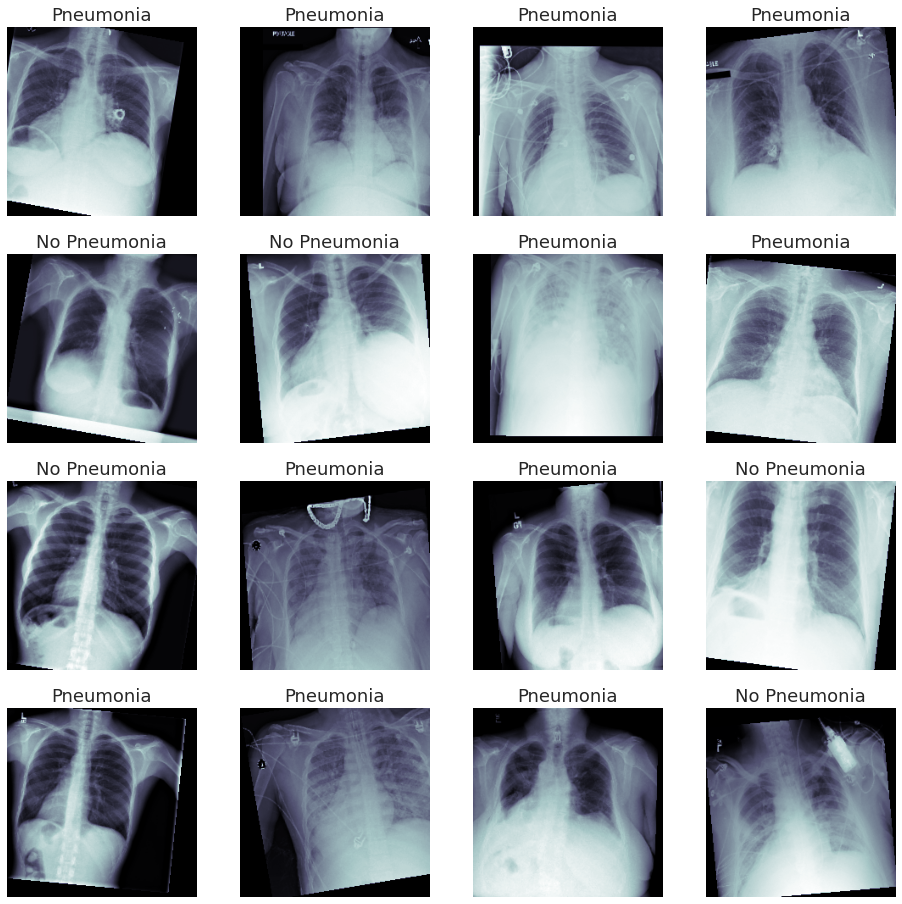

In [16]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize=(16,16))

for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='bone')
    
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    
    c_ax.axis('off')

## Build model

The chosen model is pretrained VGG16. During training it will be fine-tuned.

In [21]:
model = VGG16(include_top=True, weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 32s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [16]:
def load_pretrained_model(output_layer='block5_pool', last_nontrainable='block5_conv3', check=False):
    
    model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
    
#     transfer_layer = model.get_layer(output_layer)
    
    model = Model(inputs=model.input, outputs=model.output)
    model.trainable = False
    
    for layer in model.layers[:model.layers.index(model.get_layer(last_nontrainable))]:
        layer.trainable=False
        
    if check:
        for layer in model.layers:
            print(layer.name, layer.trainable)

    return model

In [17]:
load_pretrained_model(check=True)

58892288/58889256 [==============================] - 1s 0us/step
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [18]:
model = load_pretrained_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [17]:
def build_model():
    
    model = Sequential()

    model.add(load_pretrained_model())
    
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', TruePositives(name='true_positives')])
    
    return model

In [18]:
model = build_model()
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              51382272  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2049      
Total params: 66,099,009
Trainable params: 51,384,321
N

I got 'Required Changes' in the review that I should change the monitored value for Model Checkpoint from binary accuracy to validation loss. However, I find it challenging to have stable validation loss and thus the minimum value of the validation loss can happen somewhat at the beginning of the training by chance. That is why I am chaning the value to the training loss, because I am afraid that saved best weights would be of a model that is not quite well trained otherwise.

In [86]:
weight_path = 'vgg16_best.hdf5'

checkpoint = ModelCheckpoint(weight_path, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min', 
                             save_weights_only=True)

early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=10)

callbacks_list = [checkpoint, early]

## Training

In [87]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=50,
                    callbacks=[checkpoint])

Epoch 1/50
72/72 [==============================] - 65s 899ms/step - loss: 7.9373 - binary_accuracy: 0.5445 - true_positives: 628.0000 - val_loss: 1.3440 - val_binary_accuracy: 0.4068 - val_true_positives: 243.0000

Epoch 00001: loss improved from inf to 7.93143, saving model to vgg16_best_dropout_4.hdf5
Epoch 2/50
72/72 [==============================] - 57s 791ms/step - loss: 0.8109 - binary_accuracy: 0.5773 - true_positives: 627.0000 - val_loss: 0.8453 - val_binary_accuracy: 0.4685 - val_true_positives: 241.0000

Epoch 00002: loss improved from 7.93143 to 0.81169, saving model to vgg16_best_dropout_4.hdf5
Epoch 3/50
72/72 [==============================] - 57s 792ms/step - loss: 0.6590 - binary_accuracy: 0.6245 - true_positives: 697.0000 - val_loss: 0.8023 - val_binary_accuracy: 0.6317 - val_true_positives: 188.0000

Epoch 00003: loss improved from 0.81169 to 0.65917, saving model to vgg16_best_dropout_4.hdf5
Epoch 4/50
72/72 [==============================] - 57s 786ms/step - loss:

### Training history

In [21]:
def plot_history(history):
    epochs_range = range(len(history['binary_accuracy']))
    
    plt.figure(figsize=(25, 20))
    plt.subplot(221)
    plt.plot(epochs_range, history['binary_accuracy'], label='Train')
    plt.plot(epochs_range, history['val_binary_accuracy'], label='Val')
    plt.legend()
    plt.title('Binary Accuracy', fontsize=25)

    plt.subplot(222)
    plt.plot(epochs_range, history['true_positives'], label='Train')
    plt.plot(epochs_range, history['val_true_positives'], label='Val')
    plt.legend()
    plt.title('True Positives', fontsize=25);

    plt.subplot(223)
    plt.plot(epochs_range, history['loss'], label='Train')
    plt.plot(epochs_range, history['val_loss'], label='Val')
    plt.legend()
    plt.title('Loss', fontsize=25)
    
    return

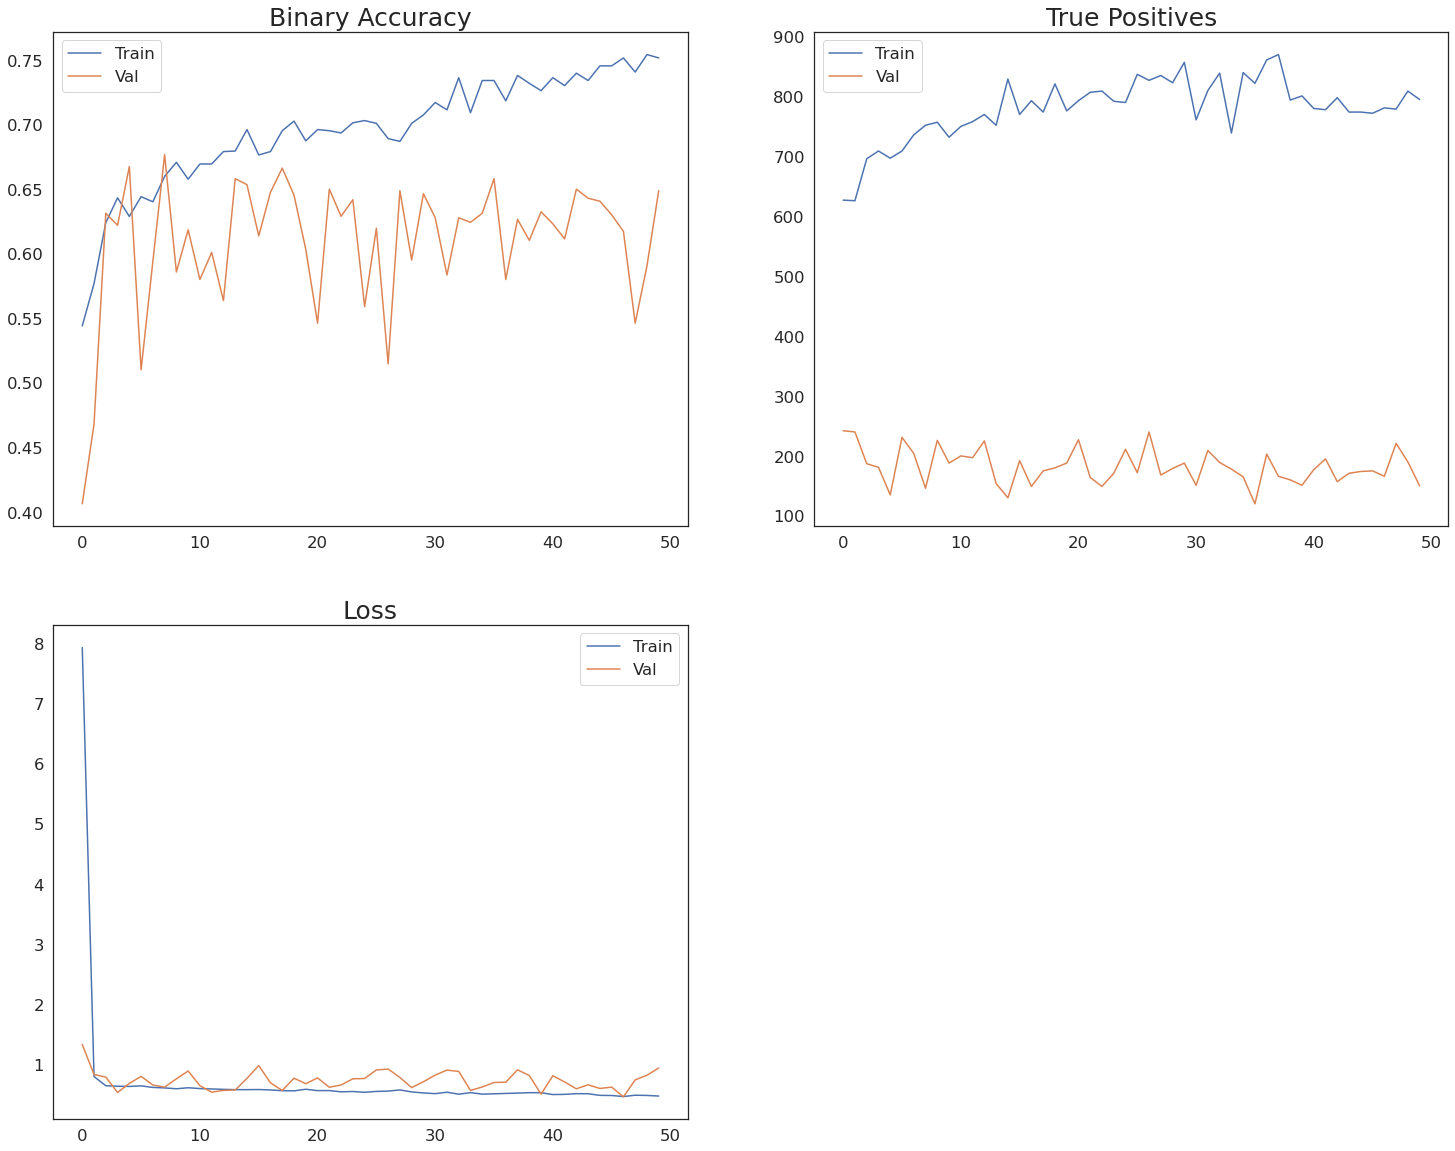

In [88]:
plot_history(history.history)

## Results

In [38]:
def plot_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(9,7))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.plot(fpr, tpr, label='AUC = {0:0.4f}'.format(roc_auc))
    
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)


def plot_precision_recall(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    avg_precision = average_precision_score(y_true, y_pred)

    plt.figure(figsize=(9,7))
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.05])

    plt.plot(recall, precision, label='AP = {0:0.4f}'.format(avg_precision))

    plt.legend(loc=3, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)

#### Batch results

In [39]:
y_pred = model.predict(X_val, verbose=True)

32/32 [==============================] - 20s 636ms/step


In [40]:
model.evaluate(X_val, y_val)

32/32 [==============================] - 20s 615ms/step


[1.0638062953948975, 0.71875, 5.0]

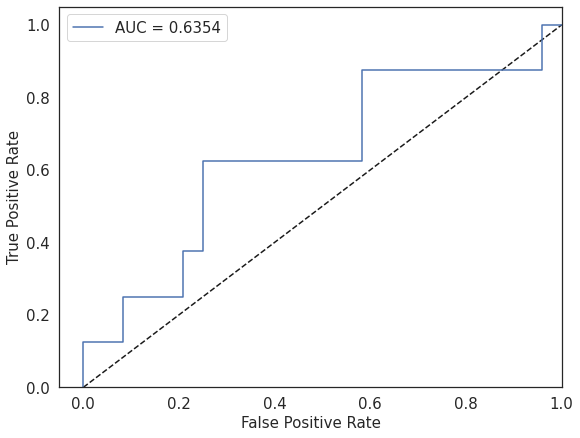

In [41]:
plot_auc(y_val, y_pred)

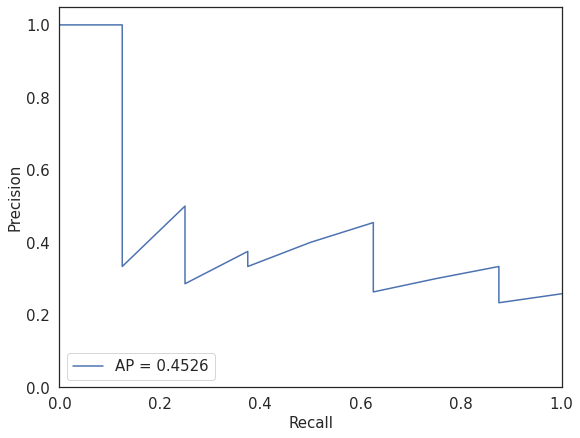

In [42]:
plot_precision_recall(y_val, y_pred)

#### Whole validation dataset results

In [78]:
number_of_examples = len(val_gen.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 32))

val_labels = []
for i in range(0,int(number_of_generator_calls)):
    val_labels.extend(np.array(val_gen[i][1]))

In [79]:
y_pred2 = model.predict(val_gen, verbose=True)

27/27 [==============================] - 13s 480ms/step


In [45]:
model.evaluate(val_gen)

27/27 [==============================] - 572s 21s/step


[1.060112476348877, 0.61771559715271, 167.0]

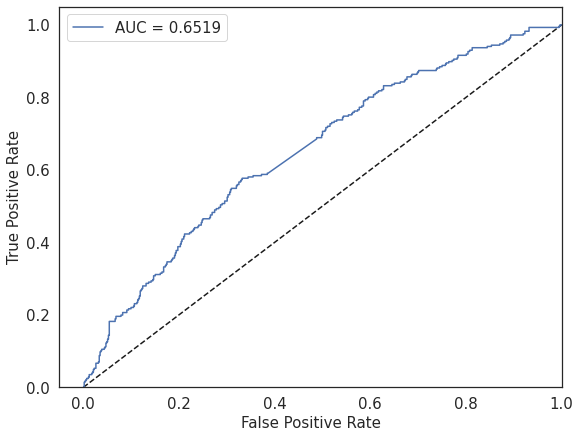

In [43]:
plot_auc(val_labels, y_pred2)

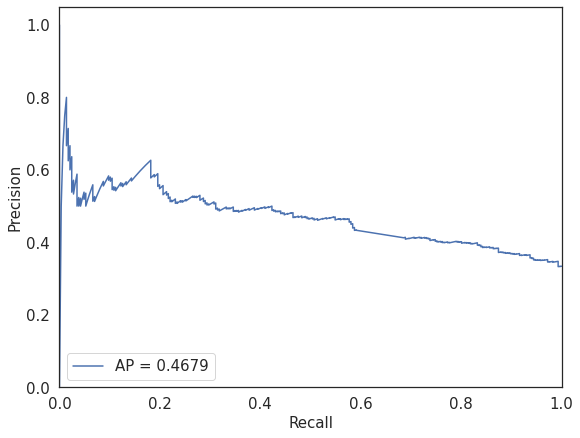

In [44]:
plot_precision_recall(val_labels, y_pred2)

## Classification threshold

Let's find a threshold that minimizes false negatives - that is maximizes recall. We don't want to miss pneumonia cases. In this clinical setting it is safer to have higher false positives (keep a patient at the hospital for treatment/further observation) in exchange for lower false negatives (mistakenly check patient as healthy and send him away).

In [19]:
model = build_model()
model.load_weights('vgg16_best.hdf5')

In [20]:
number_of_examples = len(val_gen.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 32))

val_labels = []
for i in range(0,int(number_of_generator_calls)):
    val_labels.extend(np.array(val_gen[i][1]))

In [21]:
y_pred2 = model.predict(val_gen, verbose=True)

27/27 [==============================] - 552s 20s/step


In [33]:
def plot_f1_threshold(y_true, y_pred):
    f1_scores = []
    thresholds = [x/100 for x in range(0, 101, 1)]
    
    for threshold in thresholds:
        y_pred_ = (y_pred >= threshold) * 1
        f1_scores.append(f1_score(y_true, y_pred_))
    
    plt.figure(figsize=(9,7))
    plt.xlim([0., 1.])
    plt.ylim([0., 1.05])
    
    plt.plot(thresholds, f1_scores)
    
    max_f1 = max(f1_scores)
    best_threshold = thresholds[f1_scores.index(max(f1_scores))]
    
    plt.plot([0, best_threshold], [max_f1, max_f1], 'k--')
    plt.plot([best_threshold, best_threshold], [0, max_f1], 'k--')
    plt.text(0.01, max_f1 + 0.01, 'Max F1 Score = ' + str(round(max_f1,3)), fontsize=15)
    plt.text(best_threshold + 0.01, 0.01, 'Threshold = ' + str(best_threshold), fontsize=15)
    
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')

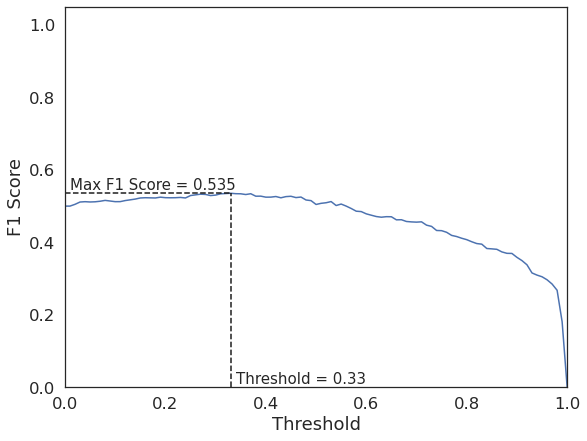

In [34]:
plot_f1_threshold(val_labels, y_pred2)

In [22]:
def classification_metrics(y_true, y_pred, classes, threshold):
    y_pred = (y_pred >= threshold) * 1
    
    print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(9, 8))
    sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, cbar=False, fmt='d', cmap='PuBu')
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.xticks(rotation=0)
    plt.yticks(va='center');

              precision    recall  f1-score   support

No Pneumonia       0.75      0.63      0.69       572
   Pneumonia       0.44      0.58      0.50       286

    accuracy                           0.62       858
   macro avg       0.60      0.61      0.60       858
weighted avg       0.65      0.62      0.63       858



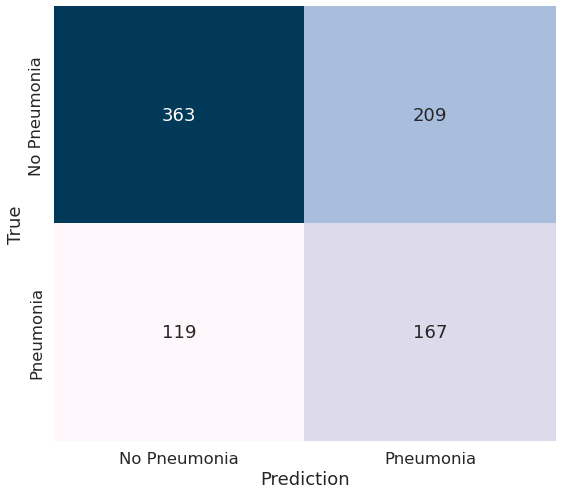

In [23]:
classification_metrics(val_labels, y_pred2, ['No Pneumonia', 'Pneumonia'], 0.5)

              precision    recall  f1-score   support

No Pneumonia       0.81      0.36      0.50       572
   Pneumonia       0.39      0.83      0.54       286

    accuracy                           0.52       858
   macro avg       0.60      0.60      0.52       858
weighted avg       0.67      0.52      0.51       858



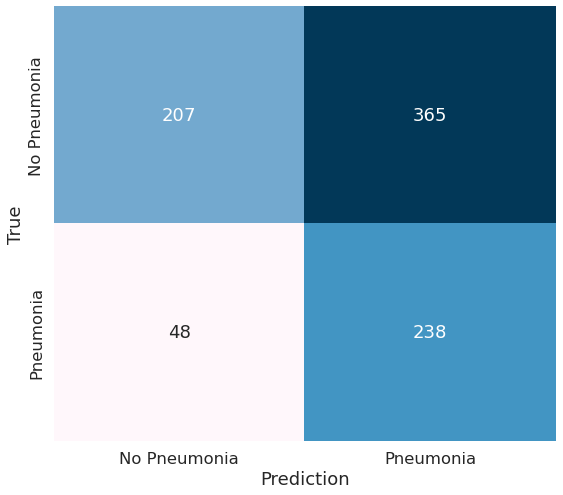

In [35]:
classification_metrics(val_labels, y_pred2, ['No Pneumonia', 'Pneumonia'], 0.33)

              precision    recall  f1-score   support

No Pneumonia       0.81      0.34      0.48       572
   Pneumonia       0.39      0.84      0.53       286

    accuracy                           0.50       858
   macro avg       0.60      0.59      0.50       858
weighted avg       0.67      0.50      0.49       858



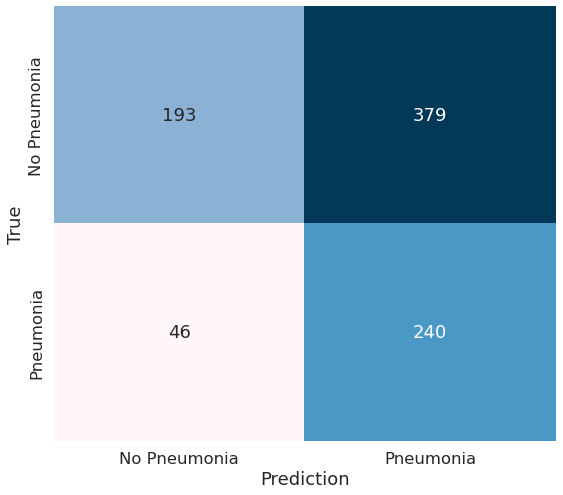

In [25]:
classification_metrics(val_labels, y_pred2, ['No Pneumonia', 'Pneumonia'], 0.3)

              precision    recall  f1-score   support

No Pneumonia       0.74      0.72      0.73       572
   Pneumonia       0.47      0.49      0.48       286

    accuracy                           0.64       858
   macro avg       0.60      0.61      0.60       858
weighted avg       0.65      0.64      0.65       858



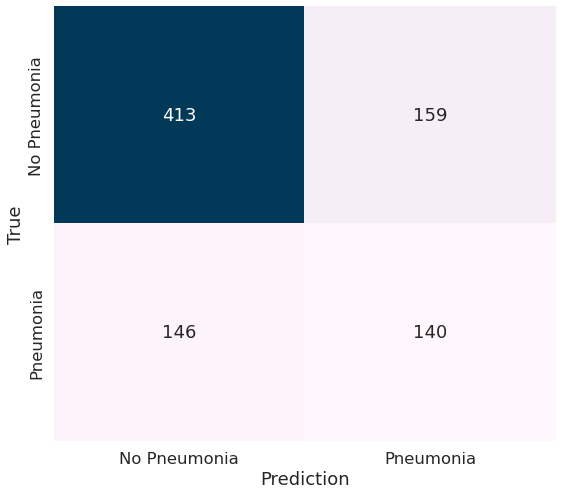

In [26]:
classification_metrics(val_labels, y_pred2, ['No Pneumonia', 'Pneumonia'], 0.6)

In [27]:
THRESHOLD = 0.33

### Exemplary predictions - chosen threshold

In [28]:
y_pred = model.predict(X_val, verbose=True)

32/32 [==============================] - 20s 611ms/step


              precision    recall  f1-score   support

No Pneumonia       0.77      0.42      0.54        24
   Pneumonia       0.26      0.62      0.37         8

    accuracy                           0.47        32
   macro avg       0.52      0.52      0.46        32
weighted avg       0.64      0.47      0.50        32



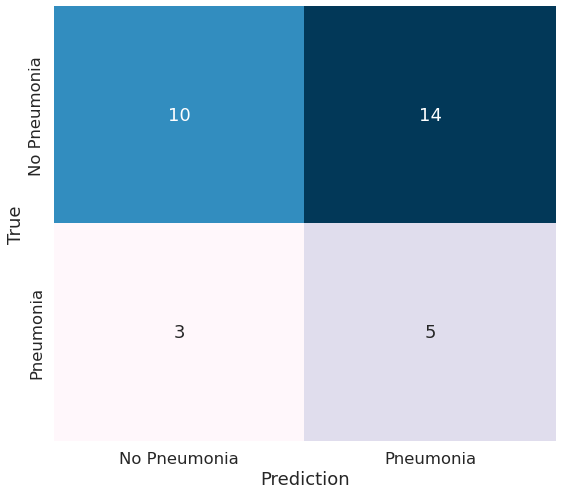

In [36]:
classification_metrics(y_val, y_pred, ['No Pneumonia', 'Pneumonia'], THRESHOLD)

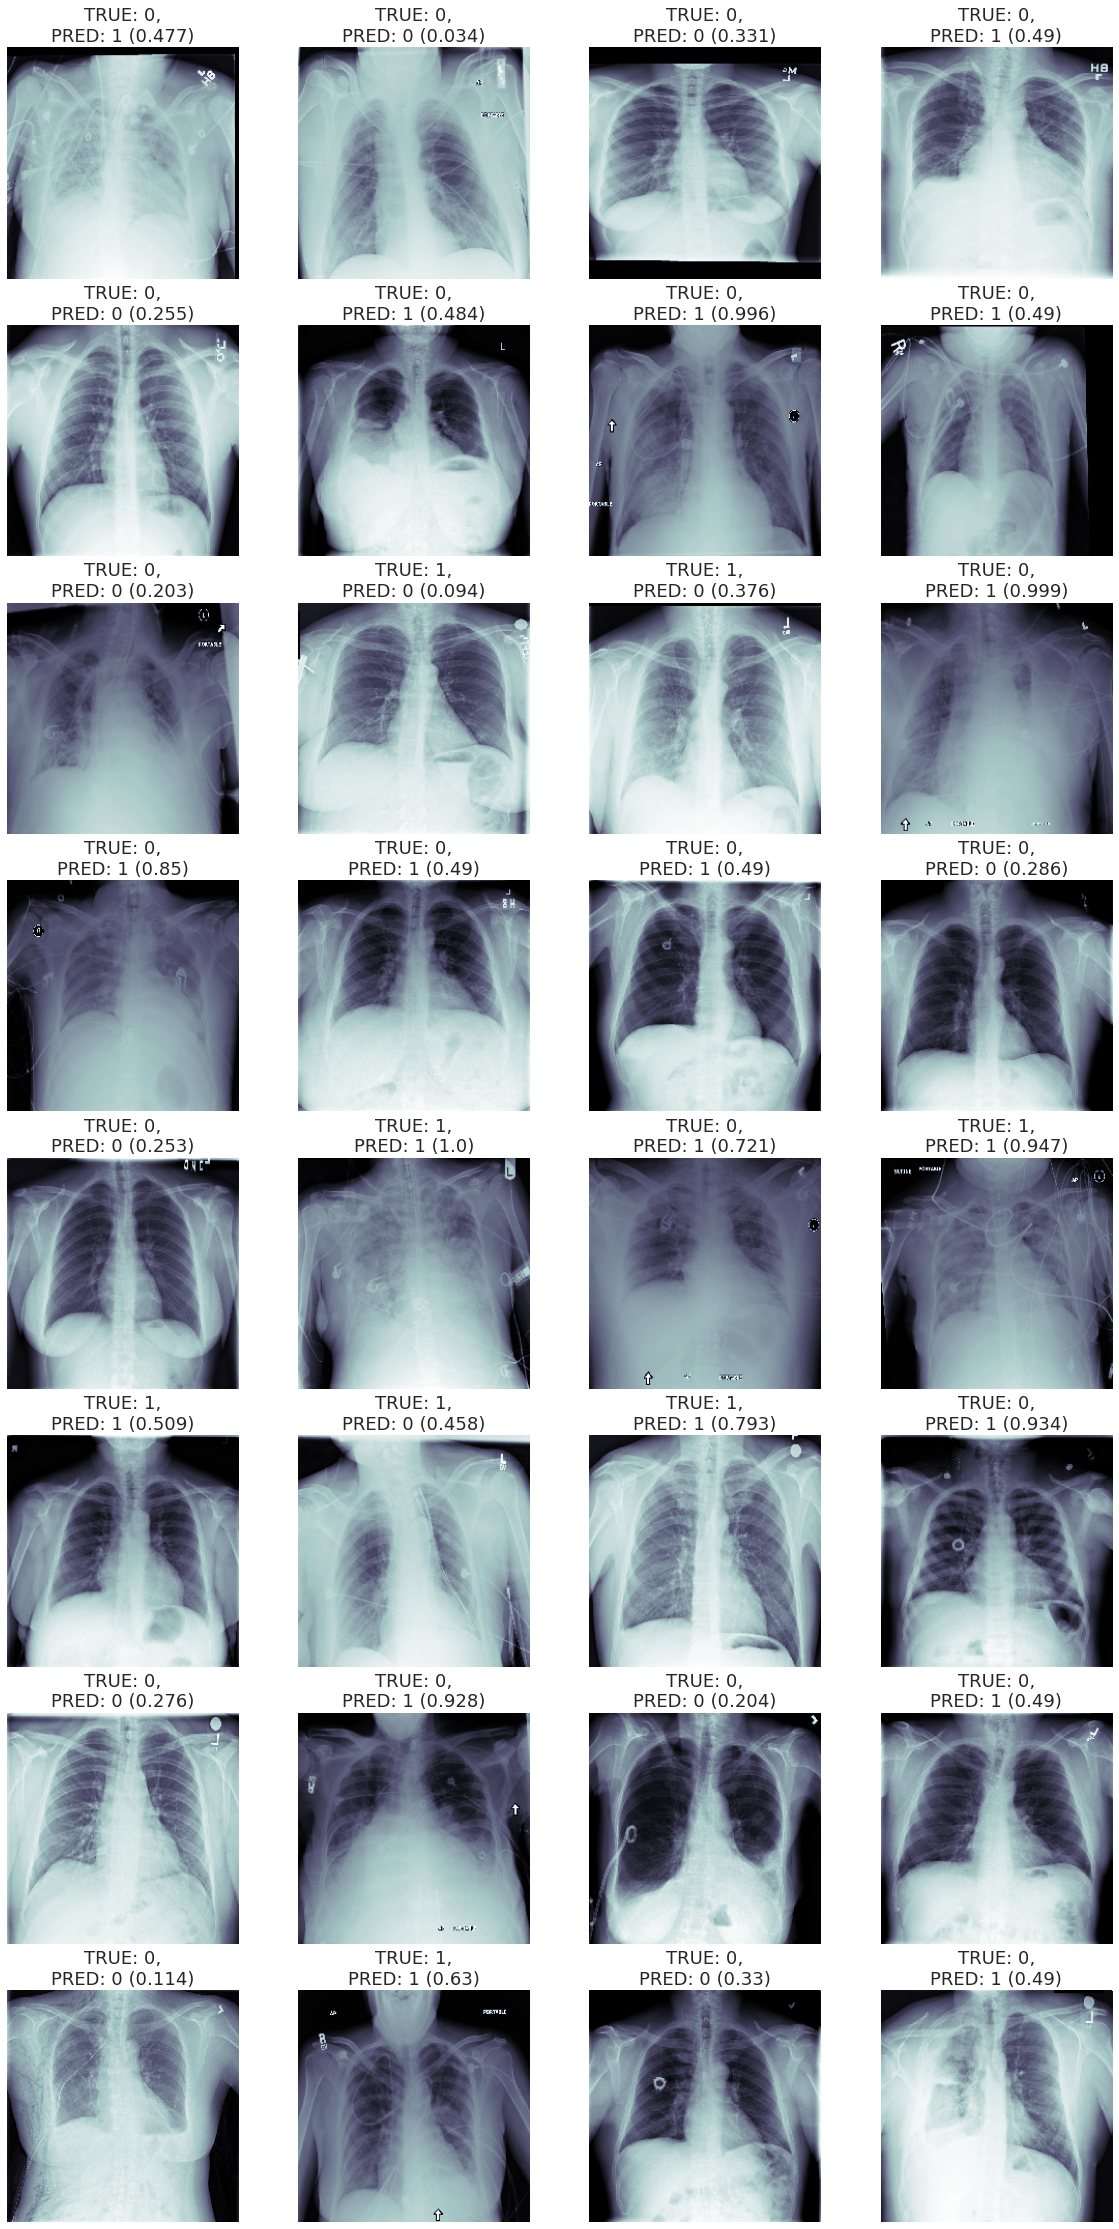

In [37]:
fig, m_axs = plt.subplots(8, 4, figsize=(20,40))
i = 0

for (c_x, c_y, c_ax) in zip(X_val, y_val, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if y_pred[i] > THRESHOLD:
            c_ax.set_title('TRUE: 1,\nPRED: 1 (' + str(round(y_pred[i][0],3)) + ')')
        else:
            c_ax.set_title('TRUE: 1,\nPRED: 0 (' + str(round(y_pred[i][0],3)) + ')')
    else:
        if y_pred[i] > THRESHOLD: 
            c_ax.set_title('TRUE: 0,\nPRED: 1 (' + str(round(y_pred[i][0],3)) + ')')
        else:
            c_ax.set_title('TRUE: 0,\nPRED: 0 (' + str(round(y_pred[i][0],3)) + ')')
    c_ax.axis('off')
    i += 1

## Save model

In [31]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)